In [17]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from skimage.transform import rotate
import pims, sys
from pathlib import Path
import trackpy as tp
import pandas as pd
from skimage.filters import butterworth, gaussian, median



In [18]:
@pims.pipeline
def crop_image(frame):
    return frame[:,0:428]


base_path = Path(r'C:\Users\jrosk\Dropbox\Warwick\TIRF\February_2023\21-02-2023\Untreated_Sample')
filepath_0 = base_path.joinpath(r'Slides\Slide_1\21-Feb-23_TIRF473-7.tif')
filepath_1 = base_path.joinpath(r'Slides\Slide_1\21-Feb-23_TIRF473-7_1.tif')


# Files being analysed

full_roi_stack_0 = pims.open(filepath_0.as_posix())
images_0 = crop_image(full_roi_stack_0)

full_roi_stack_1 = pims.open(filepath_1.as_posix())
images_1 = crop_image(full_roi_stack_1)


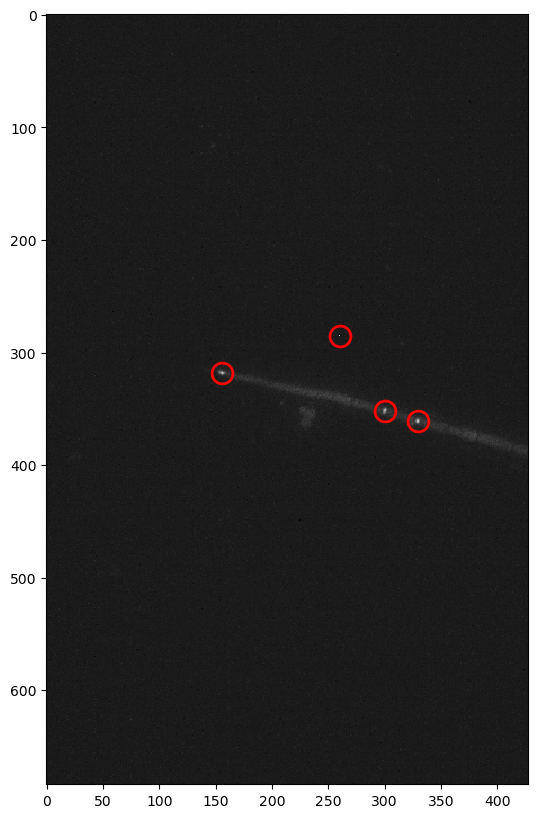

<Axes: >

In [19]:

fig, ax = plt.subplots(1,1, figsize=(10,10))
img_test = images_0[200] # gaussian(images_0[200])#, cutoff_frequency_ratio=0.02)
f = tp.locate(img_test,  diameter=5, minmass=150, separation=20, noise_size=1.0)
tp.annotate(f, img_test)

> 5. Batch process the stack, link particles into trajectories, filter short trajectories

In [20]:

all_particles_0 = tp.batch(images_0,diameter=5, minmass=150, separation=20, noise_size=1.2)
all_particles_1 = tp.batch(images_1,diameter=5, minmass=150, separation=20, noise_size=1.2)
all_particles_1['frame'] = all_particles_1['frame'] + all_particles_0['frame'].max() + 1
all_particles = pd.concat([all_particles_0, all_particles_1], ignore_index = True)

Frame 378: 4 features


In [21]:
all_linked = tp.link(all_particles, search_range=1, memory=1)
all_linked_filtered = tp.filter_stubs(all_linked, 50)

Frame 2204: 4 trajectories present.


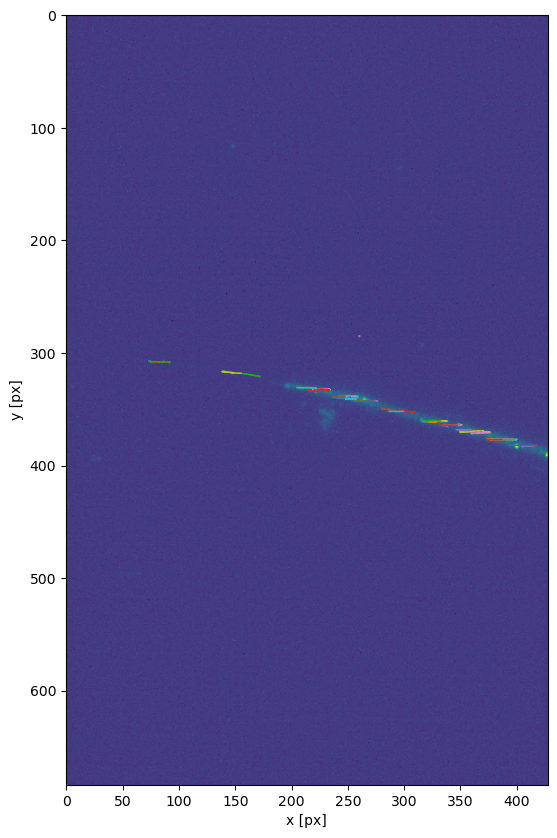

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [22]:
# Inspect results
fig, ax = plt.subplots(1,1, figsize = (10,10))
plt.imshow(images_0[0])
#plt.ylim(500,200)
tp.plot_traj(all_linked_filtered)

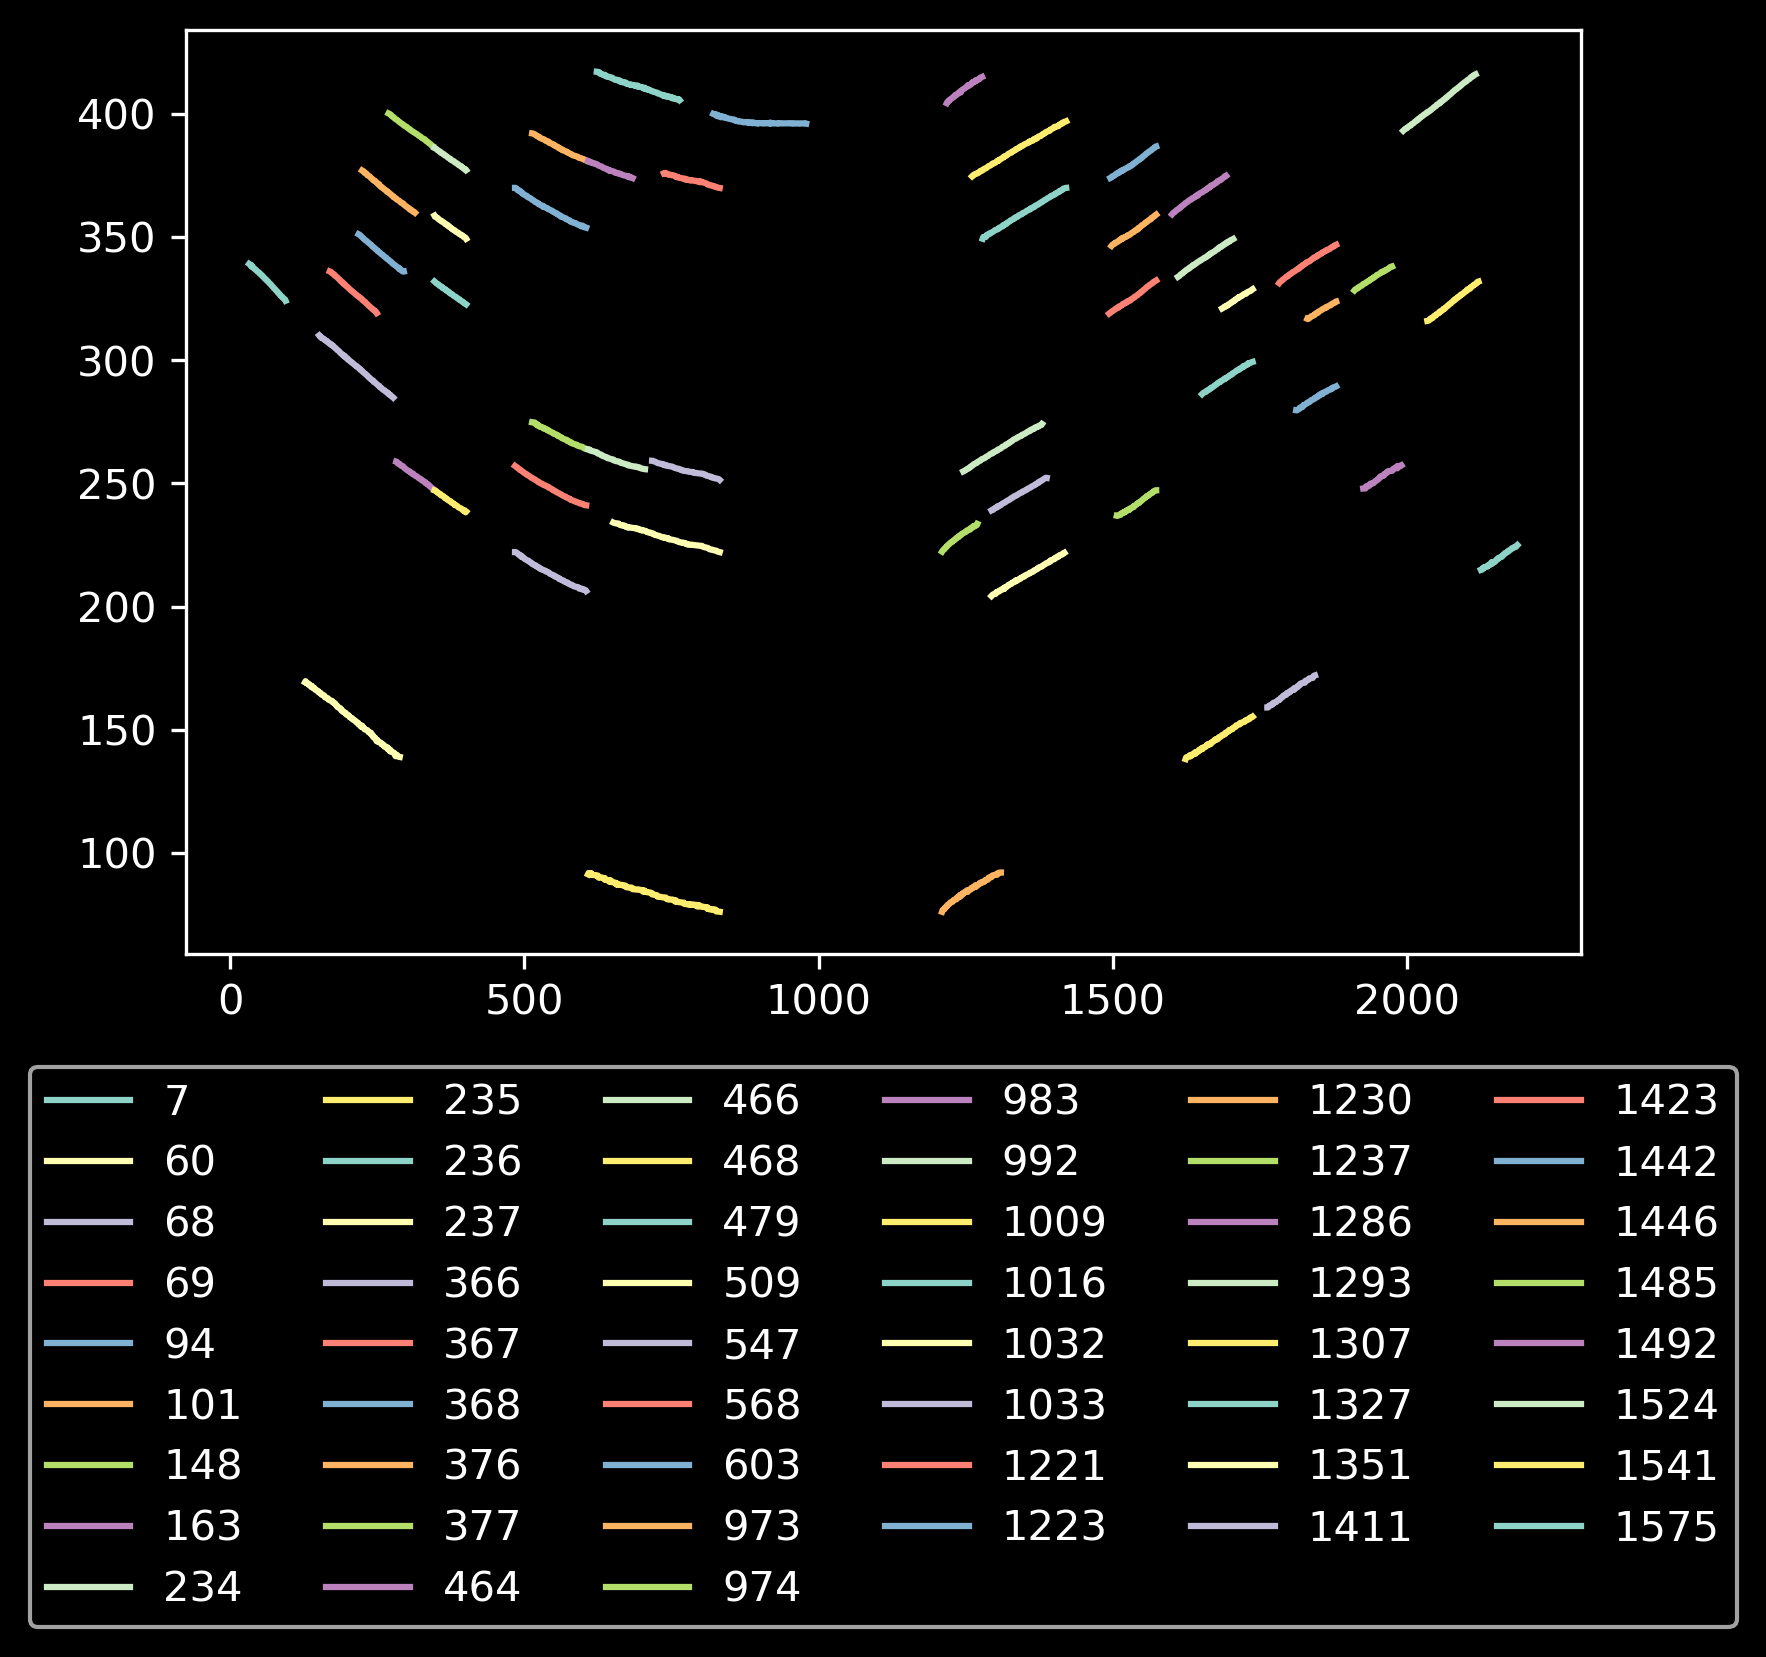

In [23]:
# there will be some artefacts, these don't really change in x coord
all_linked_filtered= all_linked_filtered.groupby('particle').filter(lambda group: group['x'].std() >= 1)


particles = all_linked_filtered['particle'].unique()

with plt.style.context('dark_background'):
    fig, ax = plt.subplots(1,1, figsize = (6,4), dpi=300)
    for particle in particles:
        data_for_particle = all_linked_filtered[(all_linked_filtered['particle'].isin(particles)) 
                                                & (all_linked_filtered['particle']==particle)]
        ax.plot(data_for_particle['frame'].values, data_for_particle['x'].values,'-', label=f'{particle}')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), ncol=6)
        #ax.annotate(f'{particle}', xy=(data_for_particle['frame'].values[0], data_for_particle['x'].values[0]), xytext=(1, 1),textcoords='offset points')
    #ax.set_ylim(258,263)
    #ax.set_xlim(1800,2500)
        

In [24]:
all_linked_filtered['experiment'] = filepath_0.stem
all_linked_filtered = all_linked_filtered.reset_index(drop=True)
all_linked_filtered.to_csv(f'tracks/{filepath_0.stem}.csv', index=False)